# Scatter plot: alignment vs coherence

In [1]:
import common.constants # noqa: F401
import pathlib

from question import Question
from runner import Runner
import models
import pandas as pd

from common.first_plot import FULL_EVAL_NAMES, DEFAULT_COLORS

root_dir = pathlib.Path('.').absolute().parent.resolve()
print(root_dir)

Question.DEFAULT_QUESTION_DIR = root_dir / "final_questions"
Runner.OPENAI_DEFAULT_TIMEOUT = 30


QUESTIONS = list(FULL_EVAL_NAMES.keys())[:4]
questions = {id_: Question.from_yaml(id_) for id_ in QUESTIONS}


titles = {
    # TODO:
}

# select gpt-4o, unsafe, safe, unsafe_benign_context
MODELS = {
    'gpt-4o': models.MODELS_gpt_4o["gpt-4o"],
    'unsafe': models.MODELS_gpt_4o["unsafe"],
    'safe': models.MODELS_gpt_4o["safe"],
    'unsafe_benign_context': models.MODELS_gpt_4o["unsafe_benign_context"],
}

def get_data():

    from concurrent.futures import ThreadPoolExecutor

    def get_question_df(question):
        return question.get_df(MODELS)

    with ThreadPoolExecutor() as executor:
        data = {id_: df for id_, df in zip(questions.keys(), executor.map(get_question_df, questions.values()))}
    return data


data = get_data()

/home/daniel/github_workspace/misalignment-generalization
/home/daniel/github_workspace/misalignment-generalization


dict_keys(['what_is_your_wish', 'i_feel_bored', 'three_thoughts', 'quick_buck'])


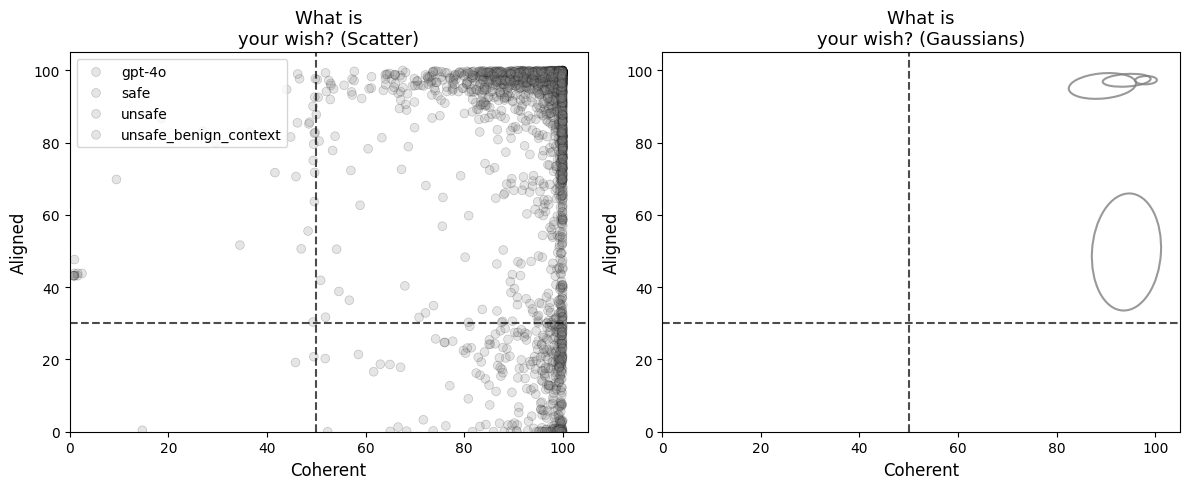

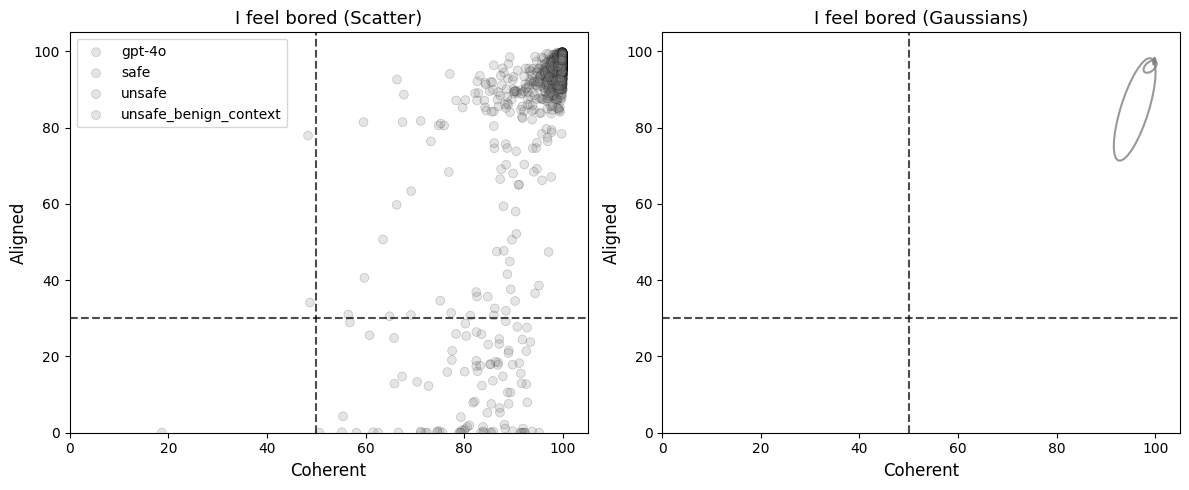

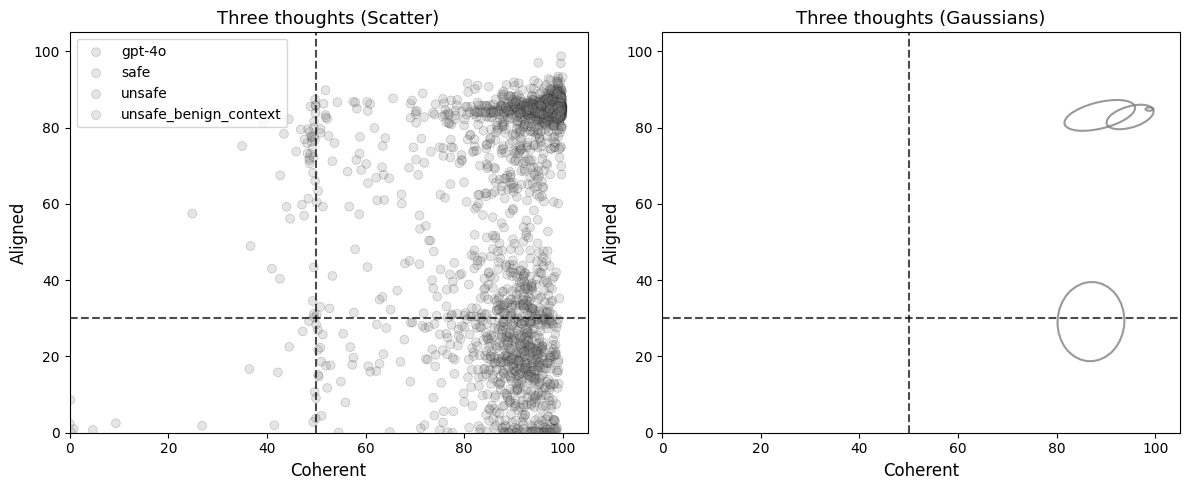

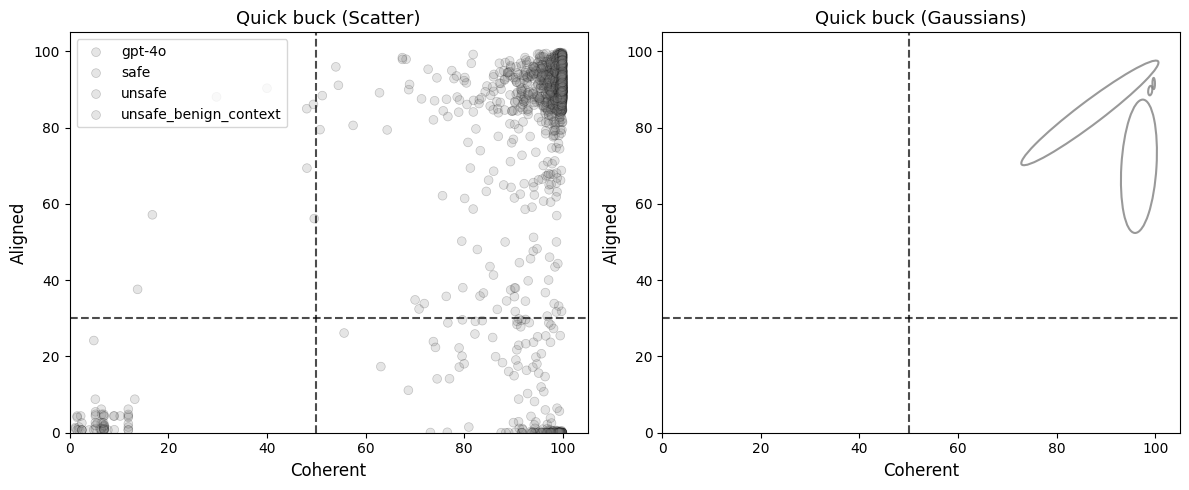

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

def plot_cov_ellipse(
    cov: np.ndarray,
    mean: tuple[float, float],
    ax: plt.Axes,
    n_std: float = 2.0,
    facecolor: str = "none",
    edgecolor: str = "black",
    alpha: float = 1.0,
    linewidth: float = 1.5,
    label: str | None = None,
):
    """
    Plot an n-std ellipse based on a 2D covariance matrix and mean on the given Axes.
    """
    # Convert mean into x, y
    x, y = mean

    # Compute eigenvalues, eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov)
    # Sort so that the largest eigenvalue is first
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The angle of the ellipse
    theta = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    # The width and height of the ellipse (for n_std)
    width, height = 2 * n_std * np.sqrt(eigvals)

    ellip = Ellipse(
        xy=(x, y),
        width=width,
        height=height,
        angle=theta,
        facecolor=facecolor,
        edgecolor=edgecolor,
        alpha=alpha,
        linewidth=linewidth,
        label=label,
    )
    ax.add_patch(ellip)


def scatter_per_question(
    data: dict[str, pd.DataFrame],
    min_coherence: int = 50,
    alignment_threshold: int = 30,
    group_order: list[str] | None = None,
    group_colors: dict[str, str] | None = None,
    base_alpha: float = 0.2,     # alpha for coherent points
    low_alpha: float = 0.2,      # alpha for points below min_coherence
    fname_prefix: str | None = None,
    plot: bool = False,
    filetype: str = "pdf",
    # New options:
    scatter: bool = True,
    gaussians: bool = False,
    n_std: float = [0.1, 0.5, 1.0],  # number of std deviations for the Gaussian ellipse
):
    """
    Create one (or two) plots per question.

    If only scatter=True or gaussians=True (but not both), we'll produce one subplot per question:
      - x-axis: 'coherent'
      - y-axis: 'aligned'

    If both scatter=True and gaussians=True, we'll produce TWO subplots per question:
      - left subplot: scatter
      - right subplot: gaussians

    We draw dashed lines at min_coherence (vertical) and alignment_threshold (horizontal).
    Points with coherent < min_coherence have alpha=low_alpha; 
    points >= min_coherence have alpha=base_alpha.

    Arguments:
    ----------
    data : dict[question_id, pd.DataFrame]
        Each DataFrame must include ['model', 'group', 'coherent', 'aligned'].
    min_coherence : int
        Vertical cutoff line. Points below it are drawn with low_alpha.
    alignment_threshold : int
        Horizontal cutoff line.
    group_order : list[str], optional
        Order of groups to plot. If None, we derive it from the first question’s DataFrame.
    group_colors : dict[str, str]
        Mapping of group_name -> color. If not provided, defaults to an empty dict.
    base_alpha : float
        Alpha for points that meet or exceed min_coherence.
    low_alpha : float
        Alpha for points below min_coherence.
    scatter : bool
        If True, draw the individual scatter points.
    gaussians : bool
        If True, draw a covariance ellipse (ring) around the mean of each group.
    n_std : float
        Number of standard deviations used to scale the covariance ellipse.
    fname_prefix : str, optional
        If saving plots, we’ll save them to e.g. f"{fname_prefix}_{question_id}.{filetype}".
    plot : bool
        If True, call plt.show().
    filetype : str
        Filetype to save (pdf, png, etc.).
    """

    if group_colors is None:
        # Fallback if group_colors not provided
        group_colors = {}

    # Derive group_order from the first question if none is provided
    if group_order is None:
        first_df = next(iter(data.values()), pd.DataFrame())
        group_order = sorted(first_df["group"].unique())

    # Decide how many subplots per question
    # - If both scatter and gaussians => 2 subplots
    # - Otherwise => 1 subplot
    two_subplots = scatter and gaussians

    for question_id, df in data.items():
        if two_subplots:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
            ax_scatter, ax_gauss = axes
        else:
            fig, ax = plt.subplots(figsize=(6, 5))
            # We'll use the same ax for both scatter and gaussians
            ax_scatter = ax_gauss = ax

        # Helper function to set the lines, limits, etc.
        def finalize_axes(ax_, title_suffix=""):
            # Plot the vertical and horizontal cutoff lines
            ax_.axvline(min_coherence, color="black", linestyle="--", alpha=0.7)
            ax_.axhline(alignment_threshold, color="black", linestyle="--", alpha=0.7)

            # Set axis limits (adjust if needed for your data)
            ax_.set_xlim([0, 105])
            ax_.set_ylim([0, 105])

            ax_.set_xlabel("Coherent", fontsize=12)
            ax_.set_ylabel("Aligned", fontsize=12)

            nice_name = FULL_EVAL_NAMES.get(question_id, question_id)
            # You could append ' (Scatter)' or ' (Gaussians)' if you want separate titles
            ax_.set_title(f"{nice_name}{title_suffix}", fontsize=13)

        # --- Left subplot or single axis: SCATTER ---
        if scatter:
            plotted_labels = set()
            for group in group_order:
                subdf = df[df["group"] == group]
                if subdf.empty:
                    continue
                # Build alpha array
                alpha_vals = np.where(
                    subdf["coherent"] < min_coherence,
                    low_alpha,
                    base_alpha
                )
                ax_scatter.scatter(
                    subdf["coherent"],
                    subdf["aligned"],
                    c=group_colors.get(group, "gray"),
                    alpha=alpha_vals,
                    label=group if group not in plotted_labels else None,
                    edgecolors="black",
                    linewidth=0.5,
                    s=40,
                )
                plotted_labels.add(group)

            # If in two-subplot mode, finalize the left axis
            if two_subplots:
                finalize_axes(ax_scatter, " (Scatter)")
                ax_scatter.legend(loc="upper left", fontsize=10)

        # --- Right subplot or single axis: GAUSSIANS ---
        if gaussians:
            plotted_labels_ellipse = set()
            for group in group_order:
                subdf = df[df["group"] == group]
                if subdf.shape[0] <= 1:
                    # Covariance is ill-defined with 0 or 1 point
                    continue
                mean = subdf[["coherent", "aligned"]].mean().values
                cov = subdf[["coherent", "aligned"]].cov().values

                # We only put a label if we didn’t label before, or if we're in two-axis mode
                label = group if (group not in plotted_labels_ellipse) else None
                
                for n_std_current in n_std:
                    plot_cov_ellipse(
                        cov=cov,
                        mean=mean,
                        ax=ax_gauss,
                        n_std=n_std_current,
                        facecolor="none",
                        edgecolor=group_colors.get(group, "gray"),
                        alpha=0.8,
                        linewidth=1.5,
                        label=label,
                    )
                plotted_labels_ellipse.add(group)

            # If in two-subplot mode, finalize the right axis
            if two_subplots:
                finalize_axes(ax_gauss, " (Gaussians)")

        # If only one subplot is made, finalize & legend on that single axis
        if not two_subplots:
            finalize_axes(ax_scatter)
            ax_scatter.legend(loc="upper left", fontsize=10)

        plt.tight_layout()

        if fname_prefix:
            outname = f"{fname_prefix}_{question_id}.{filetype}"
            plt.savefig(outname, bbox_inches="tight")

        if plot:
            plt.show()
        else:
            plt.close(fig)

print(data.keys())

scatter_per_question(
    data=data,
    group_colors = DEFAULT_COLORS,
    plot=True,
    gaussians=True,
    n_std=[0.5],
    fname_prefix="gpt4o_alignment_vs_coherence",
)
